In [1]:
!pip install torch --upgrade

     |████████████████████████████████| 881.9 MB 4.2 kB/s             
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.61 requires nvidia-ml-py3, which is not installed.


In [1]:
from sys import path
path.append("/home/ec2-user/SageMaker/data-science-development/utils")
path.append("/home/ec2-user/SageMaker/data-science-development/config")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import os
import torch
import random
import json
import datetime
import time
import scipy

from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm 

tqdm.pandas()

In [2]:
skills = pd.read_csv("../Data/skills_one-hot.csv").set_index("candidate_id")
skills.head()

,skill_1,skill_2,skill_3,skill_5,skill_6,skill_7,skill_8,skill_9,skill_12,skill_13,...,skill_3926,skill_3927,skill_3928,skill_3929,skill_3930,skill_3931,skill_3932,skill_3933,skill_3934,skill_3935
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
skills = dict(zip(skills.index, skills.values))

In [4]:
certs = pd.read_csv("../Data/candidate_certificates_one-hot.csv").set_index("candidate_id")
certs.head()

,1,10,11,12,13,14,15,16,17,18,...,W4,W5,W7,W9,WB,WC,WD,WE,WF,ZW
candidate_id,,,,,,,,,,,,,,,,,,,,,
84603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
certs = dict(zip(certs.index, certs.values))

In [6]:
licenses = pd.read_csv("../Data/licenses_one-hot.csv").set_index("candidate_id")
licenses.head()

,A,B,BE,C,CE,D,DE,G
candidate_id,,,,,,,,
84556,0,1,0,0,0,0,0,0
84612,0,0,0,0,0,0,0,1
84731,1,1,0,0,0,0,0,0
85437,0,1,0,0,0,0,0,0
85627,0,1,1,0,0,0,0,0


In [7]:
licenses = dict(zip(licenses.index, licenses.values))

In [8]:
languages = pd.read_csv("../Data/languages_one-hot.csv").set_index("candidate_id")
languages.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
84432,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
languages = dict(zip(languages.index, languages.values))

In [10]:
addresses = pd.read_csv("../Data/addresses_one-hot.csv").set_index("candidate_id")
addresses.head()

,0
candidate_id,
84556,91
84612,49
84731,3773
85437,3819
85627,1560


In [11]:
addresses = dict(zip(addresses.index, addresses.values))

In [12]:
w2v = json.load(open("../Data/embeddings.json"))
# Convert to ints
w2v = {int(k):{int(k2):v2 for k2, v2 in v.items()} for k, v in w2v.items()}

In [13]:
df_pred = pd.read_csv("../Data/df_pred_ext.csv").drop("Unnamed: 0", axis=1)

In [14]:
# df_pred = df_pred[df_pred["source"] == 0]

In [15]:
df_pred = df_pred.drop(["time_between", "job_order", "source"], axis=1)

In [16]:
# df_pred["time_between"] = (df_pred["time_between"] - df_pred["time_between"].mean()) / df_pred["time_between"].std()
df_pred["time_spent"] = (df_pred["time_spent"] - df_pred["time_spent"].mean()) / df_pred["time_spent"].std()

In [17]:
df_pred.head()

,candidate_id,time_spent,isco_functie_niveau,education,company_name,function_id,isco_code4
0,84556,-0.210459,2.0,0.0,324258,936,208
1,84556,-0.252626,1.0,0.0,324258,809,348
2,84556,-0.085012,2.0,0.0,329244,936,208
3,84556,-0.370694,1.0,0.0,368140,1519,344
4,84556,-0.363314,1.0,0.0,419826,1519,344


In [18]:
df_pred.max()

candidate_id           8.909607e+06
time_spent             3.389322e+01
isco_functie_niveau    4.000000e+00
education              5.000000e+00
company_name           4.411520e+05
function_id            2.988000e+03
isco_code4             3.540000e+02
dtype: float64

In [19]:
len(df_pred["function_id"].unique()), len(df_pred["company_name"].unique())

(2989, 267934)

In [20]:
majority_class = df_pred["isco_code4"].mode().values[0]

<AxesSubplot:>

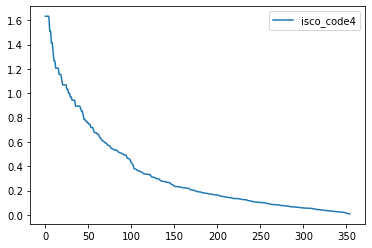

In [21]:
(2 / (0.5 * np.sqrt(df_pred["isco_code4"].value_counts().sort_values().reset_index().drop("index", axis=1)))).plot()

In [22]:
career_paths = df_pred.groupby("candidate_id")

In [23]:
candidate_lens = career_paths.apply(lambda x: len(x) - 1).to_dict()

In [24]:
num_classes = df_pred["isco_code4"].unique().max() + 1
num_features = len(career_paths.mean().columns)
num_classes, num_features

(355, 6)

In [25]:
maximum_career_duration = 25

In [26]:
# Convert to 2d-arrays, grabbing the last 25 jobs of each candidate and getting rid of candidate_ids as values
career_paths = career_paths.progress_apply(lambda x: x.values[-(maximum_career_duration + 1):,1:])

100%|██████████| 469568/469568 [00:47<00:00, 9809.83it/s] 


In [27]:
# Drop careers that are only 1 job long
career_lens = career_paths.apply(len)
career_paths = career_paths.loc[(career_lens > 1)]

In [28]:
career_paths = career_paths.loc[career_paths.apply(lambda x: x[-1][-1] != x[-2][-1])]

In [29]:
career_paths.head()

candidate_id
84556    [[-0.21045870102048395, 2.0, 0.0, 324258.0, 93...
84612    [[-0.3685852264755267, 1.0, 0.0, 201740.0, 151...
84731    [[-0.35066422025728855, 1.0, 0.0, 353745.0, 15...
85437    [[0.3313881928721292, 1.0, 2.0, 5500.0, 1519.0...
85888    [[-0.2895219637480053, 2.0, 3.0, 423330.0, 795...
dtype: object

In [30]:
idxs = []
x = []
y = []

# max_skills = len([col for col in df_pred if "skill_" in col])

for idx, career in zip(career_paths.index, career_paths.values):
    label = career[-1, -1]
    
    if not np.isnan(label):       
        idxs.append(idx)
        x.append(career[:-1].reshape(len(career) - 1, num_features))
        y.append(label)

idxs = np.array(idxs)
x = np.array(x)
y = np.array(y)

In [31]:
to_fill = np.zeros([len(x), len(max(x, key = lambda x: len(x))), num_features])

for i,j in enumerate(x):
    if len(j):
        to_fill[i][-len(j):] = j

In [32]:
max_len = len(max(x, key = lambda x: len(x)))
max_len

25

In [33]:
del df_pred
del x

In [34]:
# Filtered: (113428, 113428)
# Grouped: (176485, 176485)
len(to_fill), len(y)

(113724, 113724)

In [35]:
# to_fill = to_fill[:50000]
# y = y[:50000]

In [36]:
def create_loaders(to_fill, idxs, y, split_size=0.8, weight_type=3, batch_size=512):

    # Train test split
    split = split_size

    training = np.array(random.sample(range(len(to_fill)), int(split * len(to_fill))))
    test = np.array(list(set(range(len(to_fill))) - set(training)))

    train_indices, val_indices = idxs[training], idxs[test]
    X_train, X_val = to_fill[training], to_fill[test]
    y_train, y_val = y[training].astype(int), y[test].astype(int)

    # Class weights
    counts = (np.bincount(y_train) + 1)
    
    if weight_type == 1:
        labels_weights = 1. / counts
    elif weight_type == 2:
        labels_weights = 1. / np.sqrt(counts)
    elif weight_type == 3:
        labels_weights = 2. / (0.5 * np.sqrt(counts))
    else:
        return NotImplemented
        
    weights = labels_weights[y_train]
    sampler = WeightedRandomSampler(weights, len(weights))

    # Create dataloaders
    train_data = TensorDataset(torch.Tensor(train_indices), 
                               torch.Tensor(X_train), 
                               torch.Tensor(y_train).type(torch.LongTensor))

    trainloader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)

    val_data = TensorDataset(torch.Tensor(val_indices),
                             torch.Tensor(X_val),
                             torch.Tensor(y_val).type(torch.LongTensor))

    valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    return trainloader, valloader

In [37]:
class attention(nn.Module):
    
    def __init__(self, hidden_size):
        super(attention, self).__init__()

        # Attention layer
        self.att_fc = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
    
    def forward(self, outputs, h_n):
        
        # Deal with batches 
        outputs = outputs.transpose(0, 1)
        att_weight = []
        
        # Determine weight of each timestep
        for timestep in outputs:
            x = self.att_fc(timestep)
            att_weight.append(x)
                        
        # Normalize            
        normalized_weights = nn.functional.softmax(torch.cat(att_weight, 1), 1)
                
        # Transpose to match normalized_weights
        outputs = outputs.transpose(0, 1)
        outputs = outputs.transpose(1, 2)
        
        # Multiply each timestep by its weight
        attn_applied = (outputs * normalized_weights.unsqueeze(1)).permute(0, 2, 1)
                       
        attn_applied *= h_n.unsqueeze(1)
        attn_applied = nn.functional.relu(attn_applied)
                
        # Weighted sum over time steps
        attn_applied = attn_applied.sum(dim=1)
                
        return attn_applied, normalized_weights

In [38]:
class eLSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers,
                 skills, certs, licenses, languages, addresses, 
                 w2v, candidate_lengths, max_len, dropout_prob=0.3,
                 skill_embedding_size=50, certs_embedding_size=20,
                 license_embedding_size=3, language_embedding_size=10,
                 address_embedding_size=25, function_embedding_size=50, 
                 isco4_embedding_size=25, education_embedding_size=3, 
                 isco_level_embedding_size=3, company_embedding_size=50):
        
        super(eLSTM, self).__init__()
              
        self.num_classes = num_classes
        self.input_size = input_size + 300
        self.hidden_size = hidden_size
        
        # Static embeddings: skills, certificates, licenses, languages
        self.skill_embedding = nn.Linear(317, skill_embedding_size, bias=False)
        self.skill_embedding.weight.data = torch.randn_like(self.skill_embedding.weight) 
        
        self.certs_embedding = nn.Linear(98, certs_embedding_size, bias=False)
        self.certs_embedding.weight.data = torch.randn_like(self.certs_embedding.weight) 
        
        self.license_embedding = nn.Linear(8, license_embedding_size, bias=False)
        self.license_embedding.weight.data = torch.randn_like(self.license_embedding.weight) 
        
        self.language_embedding = nn.Linear(23, language_embedding_size, bias=False)
        self.language_embedding.weight.data = torch.randn_like(self.language_embedding.weight) 
        
        # Address embedding
        self.address_embedding = nn.Embedding(4768, address_embedding_size)       
        
        # Categorical feature embeddings isco_functie_niveau	source	education	company_name	function_id	isco_code4
        self.function_embedding = nn.Embedding(2992, function_embedding_size)
        self.isco_code_embedding = nn.Embedding(num_classes, isco4_embedding_size)
        self.company_embedding = nn.Embedding(441153, company_embedding_size)
        self.education_embedding = nn.Embedding(6, education_embedding_size)
        self.isco_level_embedding = nn.Embedding(5, isco_level_embedding_size)
        
        # -6 --> embedded features get replaced
        N = self.input_size - 5 + skill_embedding_size + certs_embedding_size + \
            license_embedding_size + language_embedding_size + address_embedding_size + \
            function_embedding_size + isco4_embedding_size + company_embedding_size + \
            education_embedding_size + isco_level_embedding_size
        
        self.conv2d = nn.Conv2d(in_channels=1,
                                out_channels=1,
                                kernel_size=(max_len, 1),
                                padding=(max_len // 2, 0))
        
        self.convrelu = nn.ReLU()
        
        self.LSTM = nn.LSTM(input_size=N * 2,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout_prob)
            
        # Attention layer
        self.attention = attention(hidden_size)
        
        self.dropout = nn.Dropout(dropout_prob)
        
        # Final fully-connected layer takes the LSTM output, as well as the static embeddings
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        
        self.softmax = nn.LogSoftmax(dim=-1)

        # Skill lookup
        self.skills = skills
        
        # Certificate lookup
        self.certs = certs
        
        # License lookup
        self.licenses = licenses
        
        # Language lookup
        self.langs = languages
        
        # Address lookup
        self.adds = addresses
        
        # w2v lookup
        self.w2v_keys = set(w2v.keys())
        self.w2v = w2v
        
        # Career durations
        self.candidate_lengths = candidate_lengths
        self.max_len = max_len      
        
        def get_from_dict(x, cdict, N):
            return cdict.get(x, np.zeros((N,)))

        self.retrieve_static = np.vectorize(get_from_dict, otypes=[np.ndarray])
                
    def w2v_lookup(self, candidate, career_duration):
        """Finds a candidate's CVs and converts them to a tensor of length career_duration"""
            
        actual_career_duration = career_duration
        career_duration = min(career_duration, max_len)
            
        # Look for cvs
        if candidate.item() in self.w2v_keys:
            cvs = self.w2v[candidate.item()]
                
            storage = []

             # If a candidate only has one CV, proceed as normal
            if len(cvs.keys()) == 1:
                w2v_list = torch.LongTensor(cvs[0]).to(device)
                w2v_list = torch.stack([w2v_list] * career_duration)
            else: # Otherwise, stack them accordingly
                ks = np.array(list(cvs.keys()))
                
                to_skip = 0
                                
                # Make sure to use candidates' most recent max_len cvs
                if actual_career_duration > self.max_len:
                    # 0, 10, 20, 30, 40, 50
                    # duration = 50
                    # ---> 0, 5, 15, 25
                                        
                    # Update to only include most recent max_len
                    ks -= max_len
                    
                    # Drop everything older than max_len time steps
                    ks_2 = np.array([ks[i] for i in range(len(ks)) if i < len(ks) and (i + 1 >= len(ks) or ks[i + 1] > 0)])
                    
                    # Store how many we need to skip while indexing
                    to_skip = len(ks) - len(ks_2)
                    
                    # Update ks
                    ks = ks_2
                    ks[0] = 0
                    
                # Due to clipping, some careers are longer than max_len
                ks = np.array([k for k in ks if k <= min(self.max_len, career_duration)])

                # Find how many time steps (rows) each CV lasted
                durations = [ks[i+1] - ks[i]
                             if i < (len(ks) - 1) 
                             else career_duration - ks[i]
                             for i in range(len(ks))]

                embed_values = list(cvs.values())

                # When the CV got updated on the last timestep, aka our test value
                # Remove it from the list of durations, as it should be ignored
                if durations[-1] == 0: 
                    durations.pop()

                # Create Tensor(s)
                if durations:
                    for i, duration in enumerate(durations):
                        # Figure out negative duration cause
                        storage.append(torch.stack([torch.Tensor(embed_values[i + to_skip])] * duration, dim=0))
                else:
                    w2v_list = torch.LongTensor(cvs[0]).to(device)

                # Combine stored tensors into a single tensor
                w2v_list = torch.cat((storage)).type(torch.LongTensor).to(device)
        else:
            w2v_list = torch.LongTensor([0] * 300).to(device)
            w2v_list = torch.stack([w2v_list] * career_duration)

        return w2v_list
 
    def forward(self, candidate, x):               
        # Default width of a row (filled with 0s)
        feature_width = torch.Tensor([0] * 500).type(torch.LongTensor).to(device)
        
        candidate_features = []
        
        skill_list = self.retrieve_static(candidate, self.skills, 317)
        skill_list = torch.LongTensor(np.stack(skill_list)).to(device)
        
        certs_list = self.retrieve_static(candidate, self.certs, 98)
        certs_list = torch.LongTensor(np.stack(certs_list)).to(device)
        
        license_list = self.retrieve_static(candidate, self.licenses, 8)
        license_list = torch.LongTensor(np.stack(license_list)).to(device)
        
        langs_list = self.retrieve_static(candidate, self.langs, 23)
        langs_list = torch.LongTensor(np.stack(langs_list)).to(device)
            
        address = self.retrieve_static(candidate, self.adds, 1)
        address = torch.LongTensor(np.stack(address)).to(device)
        
        # Embed every static feature
        skill_list, certs_list, license_list, langs_list = [self.skill_embedding(skill_list.type(torch.FloatTensor).to(device)),
                                                            self.certs_embedding(certs_list.type(torch.FloatTensor).to(device)),
                                                            self.license_embedding(license_list.type(torch.FloatTensor).to(device)),
                                                            self.language_embedding(langs_list.type(torch.FloatTensor).to(device))]
        
        # Combine and embed
        batch_features = torch.cat([skill_list, certs_list, 
                                    license_list, langs_list], dim=-1).type(torch.FloatTensor).to(device)
            
        batch_addresses = self.address_embedding(address)[:,0,:]
                
        # For each candidate in the current batch
        for i, c in enumerate(candidate):
            # Get career duration
            career_duration = self.candidate_lengths[c.item()]
                        
            # Get CV embeddings
            w2v_list = self.w2v_lookup(c, career_duration)
            
            # Reset to max_len
            career_duration = min(career_duration, max_len)

            # Only create zeros if needed (e.g. less than max_len career duration)
            if (self.max_len - career_duration) > 0:
                zeros = torch.stack([feature_width] * (self.max_len - career_duration))
            else: # Reset zeros to prevent shape mismatch
                zeros = torch.LongTensor([]).to(device)
                   
            # Broadcast and add static features
            static_features = torch.stack([batch_features[i]] * career_duration).type(torch.LongTensor).to(device)
            address_emb = torch.stack([batch_addresses[i]] * career_duration).type(torch.LongTensor).to(device)
            
            # Combine w2v, static features, and address
            full_features = torch.cat([w2v_list, static_features, address_emb], dim=1)
                                    
            # Broadcast CV, static, and address to the correct length
            full_features = torch.cat([zeros, full_features], dim=0)
                    
            # Store result
            candidate_features.append(full_features)
                                
        # Convert list of tensors to actual tensor
        additional_features = torch.stack((candidate_features)).type(torch.FloatTensor).to(device)
                
        # isco_functie_niveau, education, function_id, isco_code4
        isco_level, education, company_name, function_id, isco_code = [x[:,:,-5],
                                                                       x[:,:,-4],
                                                                       x[:,:,-3],
                                                                       x[:,:,-2],
                                                                       x[:,:,-1]]
        
        x = x[:,:,:-5].to(device)
        
        isco_level_smoothing = (isco_level != 0).unsqueeze(-1)
        education_smoothing = (education != 0).unsqueeze(-1)
        company_name_smoothing = (company_name != 0).unsqueeze(-1)
        function_id_smoothing = (function_id != 0).unsqueeze(-1)
        isco_code_smoothing = (isco_code != 0).unsqueeze(-1)
                
        isco_level, education, company_name, function_id, isco_code  = [self.isco_level_embedding(isco_level.type(torch.LongTensor).to(device)) * isco_level_smoothing,
                                                                        self.education_embedding(education.type(torch.LongTensor).to(device)) * education_smoothing,
                                                                        self.company_embedding(company_name.type(torch.LongTensor).to(device)) * company_name_smoothing,
                                                                        self.function_embedding(function_id.type(torch.LongTensor).to(device)) * function_id_smoothing,
                                                                        self.isco_code_embedding(isco_code.type(torch.LongTensor).to(device)) * isco_code_smoothing]   
                
        # Add features
        x = torch.cat([x, isco_level, education, company_name, function_id, isco_code, additional_features], dim=2)

        # CNN
        x2 = self.conv2d(x.unsqueeze(1))
        x2 = self.convrelu(x2)
        x2 = x2.squeeze(1)
        
        x2 = self.dropout(x2)

        # TODO: Look into how to concatenate these two?
        x = torch.cat([x, x2], dim=2)
                
        # LSTM
        x, (h_n, c_n) = self.LSTM(x)
        
        # In case of multiple LSTMs, take the last h_n
        if h_n.size(0) > 1:
            h_n = h_n[-1]
        
        h_n = h_n.squeeze(0)
                
        # Apply attention
        context, weight = self.attention(x, h_n)
        
        # Combine the context and the lstm output
        x = torch.cat([h_n, context], dim=1)
        
        x = self.dropout(x)
                
        # Fully-connected
        out = self.fc(x)

        # softmax
        out = self.softmax(out)
                        
        return out, weight, career_duration

In [39]:
def train_loop(model, trainloader, valloader, optimizer, scheduler, criterion, num_epochs):

    results = defaultdict(list)
    
    passed = [0]
    training_losses = [6]
    test_losses = [6]
    accuracy = [0]
    
    highest_performance = 0
    
    # Train the model
    for epoch in range(num_epochs):
        start = time.time()
        print("-------------------------------------------------------------------------------")
        print(f"Epoch starting at: {datetime.now().strftime('%H:%M:%S')}")
        
        training_loss = 0
        
        for i, (candidate, career, job) in enumerate(trainloader):
            career, job = career.to(device), job.to(device)
            optimizer.zero_grad()

            outputs, weight, _ = model(candidate, career)
                        
            # obtain the loss function
            loss = criterion(outputs, job)
            loss = loss.mean()           
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            
            print("Epoch: %d, batch: %d/%d, loss: %1.5f" % (epoch + 1, i + 1, len(trainloader), loss.item()), end="\r")
                    
        training_loss /= len(trainloader)
               
        stats = test_loop(valloader, model, criterion)
        
        done = int(time.time() - start)        
        print(f"Epoch duration: {int((done) // 60)}:{int((done) % 60):02d}")
        
        with open(f"../logs/eCNN-LSTM/{datetime.now().strftime('%Y_%d_%m_%H:%M:%S')}.txt", "w+") as f:
            f.write(f"{model}\n\nEpoch: {epoch + 1}\n\nAcc@1: {stats[0]}\n\nDuration: {int(done // 60)}:{int(done % 60):02d}")

        results["Epoch"].append(epoch + 1)
        results["Acc@1"].append(stats[0])
        results["Acc@5"].append(stats[1])
        results["Acc@10"].append(stats[2])
        results["Acc@20"].append(stats[3])
        results["test_loss"].append(stats[4])
        results["training_loss"].append(training_loss)
        results["duration"].append(done)
        
        if stats[0] > highest_performance:
            torch.save(model.state_dict(), "../models/eCNN-LSTM_5.pt")
            highest_performance = stats[0]
        
        scheduler.step()
                
        passed.append(epoch + 1)
        training_losses.append(training_loss)
        test_losses.append(stats[4])
        accuracy.append(stats[0])
        
        plt.plot(passed, training_losses, label="Training Loss")
        plt.plot(passed, test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.legend()
        plt.show()
        
#         plt.plot(passed, accuracy)
#         plt.xlabel("Epoch")
#         plt.ylabel("Accuracy")
#         plt.show()
                
    return results
        
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, acc1, acc5, acc10, acc20 = 0, 0, 0, 0, 0
    
    with torch.no_grad():
        for candidate, career, job in dataloader:
            career, job = career.to(device), job.to(device)
            pred, weight, _ = model(candidate, career)
            
            test_loss += criterion(pred, job).mean().item()
            acc1 += (pred.argmax(1) == job).type(torch.float).sum().item()
            
            sorted_preds = torch.argsort(pred, 1, descending=True)
            
            at5 = []
            at10 = []
            at20 = []
            
            for answer, predictions in zip(job, sorted_preds):
                at5.append(answer.item() in predictions[:5])
                at10.append(answer.item() in predictions[:10])
                at20.append(answer.item() in predictions[:20])
            
            acc5 += np.sum(at5)
            acc10 += np.sum(at10)
            acc20 += np.sum(at20)
            
    test_loss /= num_batches
    acc1 /= size
    acc5 /= size
    acc10 /= size
    acc20 /= size
    print(f"\nTest Error:")
    print(f"Acc@1: {(100*acc1):>0.2f}%, Acc@5: {100*acc5:>0.2f}%, " +\
          f"Acc@10: {100*acc10:>0.2f}%, Acc@20: {100*acc20:>0.2f}% Avg loss: {test_loss:>8f}")
    
    return acc1, acc5, acc10, acc20, test_loss

In [40]:
torch.cuda.empty_cache()

In [119]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 15
current = 0

criterion = torch.nn.CrossEntropyLoss()

full_results = []

learning_rates = [1e-2, 1e-3, 1e-4][1:2]
hidden_sizes = [500, 1000, 1500, 2000][1:2]
num_layerss = [1, 3][:1]
batch_sizes = [128, 256, 512, 1024, 2048, 4096][-2:-1]
dropout_probs = [0, 0.25, 0.5][:1]

skill_embedding_size=100
certs_embedding_size=50
license_embedding_size=10
language_embedding_size=15
address_embedding_size=25
function_embedding_size=250
isco4_embedding_size=150
education_embedding_size=10
isco_level_embedding_size=10
company_embedding_size=300
w2v_embedding_size = 300

try:        
    for learning_rate in learning_rates:
        for hidden_size in hidden_sizes:
            for num_layers in num_layerss:
                for dropout in dropout_probs:
                    for batch_size in batch_sizes:

                        lstm = eLSTM(num_classes=num_classes,
                                     input_size=num_features,
                                     hidden_size=hidden_size,
                                     num_layers=num_layers,
                                     dropout_prob=dropout,
                                     skills=skills, 
                                     certs=certs,
                                     licenses=licenses,
                                     languages=languages,
                                     addresses=addresses,
                                     w2v=w2v,
                                     skill_embedding_size=skill_embedding_size,
                                     certs_embedding_size=certs_embedding_size,
                                     license_embedding_size=license_embedding_size,
                                     language_embedding_size=language_embedding_size,
                                     address_embedding_size=address_embedding_size,
                                     function_embedding_size=function_embedding_size,
                                     isco4_embedding_size=isco4_embedding_size,
                                     education_embedding_size=education_embedding_size,
                                     isco_level_embedding_size=isco_level_embedding_size,
                                     company_embedding_size=company_embedding_size,
                                     candidate_lengths=candidate_lens,
                                     max_len=max_len)

                        lstm = lstm.to(device)

                        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
                        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

                        if current >= 1:
                            print("\n\n\n")

                        print(f"Current iteration {current}/{len(learning_rates) * len(hidden_sizes) * len(num_layerss) * len(dropout_probs) * len(batch_sizes)}")
                        print(f"- Initial learning rate: {learning_rate}\n- Batch size: {batch_size}\n- Model: \n\n", lstm, "\n")

                        trainloader, valloader = create_loaders(to_fill, idxs, y, split_size=0.8, 
                                                                weight_type=3, batch_size=batch_size)

                        # Store results of current configuration
                        outcome = train_loop(lstm, trainloader, valloader, optimizer, scheduler, criterion, num_epochs)
                        outcome["lr"] = [learning_rate] * num_epochs
                        outcome["Nodes per layer"] = [hidden_size] * num_epochs
                        outcome["Number of layers"] = [num_layers] * num_epochs
                        outcome["Dropout"] = [dropout] * num_epochs
                        outcome["Batch size"] = [batch_size] * num_epochs

                        full_results.append(outcome)

                        with open("../results/eCNN-LSTM.json", "w") as current_stats:
                            json.dump(full_results, current_stats)
                        
                        current += 1

            break
        break
except KeyboardInterrupt:
    pass

Current iteration 0/1
- Initial learning rate: 0.001
- Batch size: 2048
- Model: 

 eLSTM(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2992, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (conv2d): Conv2d(1, 1, kernel_size=(25, 1), stride=(1, 1), padding=(12, 0))
  (convrelu): ReLU()
  (LSTM): LSTM(2442, 1000, batch_first=True)
  (attention): attention(
    (att_fc): Linear(in_features=1000, out_features=1, bias=True)
    (relu): ReLU()
  )
  (dropout): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=2000, out_features=3

In [43]:
# torch.save(lstm.state_dict(), "../models/eCNN-LSTM.pt")


In [ ]:
merge_results = defaultdict(list)

for res in full_results:
    for k, v in res.items():
        merge_results[k].extend(v)
        
total = pd.DataFrame(merge_results).set_index(["lr", "Nodes per layer", "Number of layers", "Dropout", "Batch size", "Epoch"])

In [ ]:
total

In [99]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

skill_embedding_size=100
certs_embedding_size=50
license_embedding_size=10
language_embedding_size=15
address_embedding_size=25
function_embedding_size=250
isco4_embedding_size=150
education_embedding_size=10
isco_level_embedding_size=10
company_embedding_size=300
w2v_embedding_size = 300

lstm = eLSTM(num_classes=num_classes,
             input_size=num_features,
             hidden_size=1000,
             num_layers=1,
             dropout_prob=0,
             skills=skills, 
             certs=certs,
             licenses=licenses,
             languages=languages,
             addresses=addresses,
             w2v=w2v,
             skill_embedding_size=skill_embedding_size,
             certs_embedding_size=certs_embedding_size,
             license_embedding_size=license_embedding_size,
             language_embedding_size=language_embedding_size,
             address_embedding_size=address_embedding_size,
             function_embedding_size=function_embedding_size,
             isco4_embedding_size=isco4_embedding_size,
             education_embedding_size=education_embedding_size,
             isco_level_embedding_size=isco_level_embedding_size,
             company_embedding_size=company_embedding_size,
             candidate_lengths=candidate_lens,
             max_len=max_len)

lstm.load_state_dict(torch.load("../models/eCNN-LSTM_4.pt"))

<All keys matched successfully>

In [100]:
lstm.to(device)

eLSTM(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2992, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (conv2d): Conv2d(1, 1, kernel_size=(25, 1), stride=(1, 1), padding=(12, 0))
  (convrelu): ReLU()
  (LSTM): LSTM(2442, 1000, batch_first=True)
  (attention): attention(
    (att_fc): Linear(in_features=1000, out_features=1, bias=True)
    (relu): ReLU()
  )
  (dropout): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=2000, out_features=355, bias=True)
  (softmax): LogSoftmax(dim=-1)
)

In [74]:
trainloader, valloader = create_loaders(to_fill, idxs, y, split_size=0.99, 
                                        weight_type=3, batch_size=2048)

In [44]:
# total.to_csv("../results/eCNN-LSTM-results_3.csv")

Batch accuracy: 0.6630859375

Previous-job baseline accuracy: 0.0
Majority class accuracy: 0.11767578125

Fraction of previous job predictions: 0.00048828125
Majority class predictions: 0.1064453125


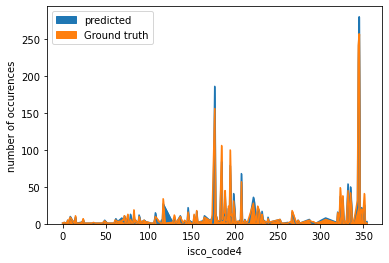

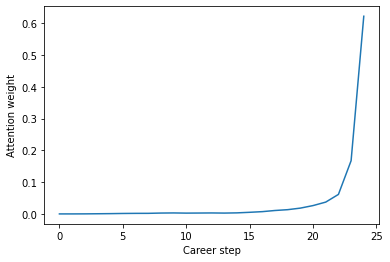

In [46]:
with torch.no_grad():
    for candidate, career, job in valloader:
        career, job = career.to(device), job.to(device)
        pred, weight, _ = lstm(candidate, career)
        
        print("Batch accuracy:", (pred.argmax(1) == job).type(torch.float).mean().item())        
        print()
        
        # Check how often the model predicted the previous job + compare to baseline performance
        previous_job = torch.Tensor(career_paths.loc[candidate.cpu()].apply(lambda x: x[-2][-1]).values).to(device)
        print("Previous-job baseline accuracy:", (job == previous_job).cpu().numpy().mean())
        print("Majority class accuracy:", (job == majority_class).cpu().numpy().mean())
        print()
        
        print("Fraction of previous job predictions:", (pred.argmax(1) == previous_job).cpu().numpy().mean())
        print("Majority class predictions:", (pred.argmax(1) == majority_class).cpu().numpy().mean())
 
        b = pd.Series(Counter(pred.argmax(1).tolist()))
        b.sort_index().plot(kind="area", label="predicted")
        
        a = pd.Series(Counter(job.tolist()))
        a.sort_index().plot(kind="area", label="Ground truth")
                
        plt.xlabel("isco_code4")
        plt.ylabel("number of occurences")
        plt.legend()
        
        plt.show()
        
        # TODO: this now includes the last CNN layer
        a = weight.cpu().detach().numpy().mean(axis=0)            
        plt.plot(a, label="average")
        # plt.plot(weights[0][np.random.choice(range(len(weights[0])))].cpu().detach().numpy(), label="random example")
        plt.xlabel("Career step")
        plt.ylabel("Attention weight")
        plt.show()
        
        break

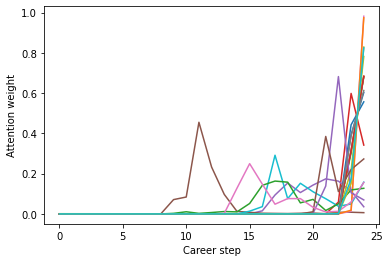

In [47]:
b = weight.cpu().detach().numpy()

for _ in range(20):
    c = np.random.randint(0, len(b))
    plt.plot(b[c])
    plt.xlabel("Career step")
    plt.ylabel("Attention weight")

In [101]:
class Guided_backprop():
    def __init__(self, model):
        self.model = model
        self.gradients = None # store R0
        self.activation_maps = []  # store f1, f2, ... 
        self.model.eval()
        
        self.update_relus()
        
    def update_relus(self):
        
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0] 
            
        # Register hook to the first layer
        first_layer = list(self.model.named_children())[0][1]
        first_layer.register_backward_hook(hook_function)

        def forward_hook_fn(module, input, output):
            self.activation_maps.append(output)

        def backward_hook_fn(module, grad_in, grad_out):
            grad = self.activation_maps.pop() 
            # for the forward pass, after the ReLU operation, 
            # if the output value is positive, we set the value to 1,
            # and if the output value is negative, we set it to 0.
            grad[grad > 0] = 1 
            
            # grad_out[0] stores the gradients for each feature map,
            # and we only retain the positive gradients
            positive_grad_out = torch.clamp(grad_out[0], min=0.0)
            new_grad_in = positive_grad_out * grad

            return (new_grad_in,)
        
        modules = list(self.model.named_children())
                        
        # travese the modules，register forward hook & backward hook
        # for the ReLU
        for name, module in modules:
            if isinstance(module, nn.ReLU):
                module.register_forward_hook(forward_hook_fn)
                module.register_backward_hook(backward_hook_fn)
                                
        # register backward hook for the first conv relu layer
        name, first_layer = modules[-6]
        
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, candidate, career, target_class):        
        model_output, weight, career_duration = self.model(candidate, career)
        
        self.model.zero_grad()
        pred_class = model_output.argmax().item()
                            
        grad_target_map = torch.zeros(model_output.shape,
                                      dtype=torch.float).to(device)
        if target_class is not None:
            grad_target_map[0][target_class] = 1
        else:
            grad_target_map[0][pred_class] = 1
        
        model_output.backward(grad_target_map)
        
        result = self.gradients.data[0].numpy()[0]
        return result, weight, pred_class, career_duration

In [102]:
device = "cpu"

In [103]:
# result = result / result.sum()

In [104]:
# x, isco_level, source, education, company_name, function_id, isco_code, w2v_list, skill_list, certs_list, license_list, langs_list, address_emb
feature_names = ["Time spent", "isco level", "education", "company name", "function", "isco code",
                 "cv", "skills", "certificates", "licenses", "languages", "location"]

# skill_embedding_size=50
# certs_embedding_size=20
# license_embedding_size=3
# language_embedding_size=10
# address_embedding_size=25
# function_embedding_size=50 
# isco4_embedding_size=25
# education_embedding_size=3
# isco_level_embedding_size=3
# company_embedding_size=50
# w2v_embedding_size = 300

embedding_sizes= [0, 1, isco_level_embedding_size, education_embedding_size, company_embedding_size, function_embedding_size, 
                  isco4_embedding_size, w2v_embedding_size, skill_embedding_size, certs_embedding_size, 
                  license_embedding_size, language_embedding_size, address_embedding_size]

In [105]:
def calculate_gradients(model, dataloader, batch=False, enforce_correct=False, group=None, min_len=3, max_len=12):
    guided_bp = Guided_backprop(model.to(device))

    pred_class, correct = 0, enforce_correct
    
    # ISCO codes for our recruiters' expertises
    if group == "Finance":
        allowed = {i - 1 for i in {5, 20, 70, 71, 72, 73, 74, 75, 142, 143, 146, 195}}
    elif group == "Healthcare":
        allowed = {i - 1 for i in{16, 17, 48, 49, 50, 51, 52, 53, 54, 55, 
                                  56, 57, 58, 59, 60, 127, 128, 129, 130,
                                  131, 132, 133, 134, 135, 136, 137, 138,
                                  140, 141, 128, 234, 235, 236}}
    elif group == "Customer_support":
        allowed = {i - 1 for i in {152, 183, 185, 186, 187, 188, 189, 190, 191, 192}}
    else:
        allowed = set(range(0, 355))
        
    # Make sure to get a correct prediction
    while pred_class != correct:
        current = next(iter(dataloader))

        if batch==False:
            candidate, career = current[0][0].unsqueeze(0), current[1][0].unsqueeze(0).to(device)
            correct = current[2][0].item()
        else:
            candidate, career = current[0], current[1].to(device)
            correct = current[2]
            
        if correct in allowed:
            result, weight, pred_class, career_duration = guided_bp.generate_gradients(candidate, career, None)

            print(pred_class, correct, career_duration, end="\r")
            # If we made a prediction that is not within the category we are looking for, reset
            if pred_class not in allowed or career_duration < min_len or career_duration > max_len:
                pred_class = -1

    if not enforce_correct:
        if batch==False:
            candidate, career = current[0][0].unsqueeze(0).to(device), current[1][0].unsqueeze(0).to(device)
            correct = current[2][0].item()
        else:
            candidate, career = current[0], current[1]
            correct = current[2]
        
        result, weight, pred_class, career_duration = guided_bp.generate_gradients(candidate, career, None)
    
    return result, weight, pred_class, correct, career, candidate, career_duration

In [106]:
def merge_layers(output, embedding_sizes):
    """order: start=0, reg_features, isco_level_embedding_size, source_embedding_size, 
              education_embedding_size, company_embedding_size, function_embedding_size, 
              isco4_embedding_size, w2v_embedding_size, skill_embedding_size, 
              certs_embedding_size, license_embedding_size, language_embedding_size, 
              address_embedding_size"""
    
    idxs = np.cumsum(embedding_sizes)
        
    result = np.stack([output[idxs[i]:idxs[i+1]].mean(axis=0) for i in range(len(idxs) - 1)])
        
    return result

In [107]:
def draw_explanation(model, dataloader, embedding_sizes, feature_names, 
                     batch=False, enforce_correct=False, group=None, 
                     min_len=3, max_len=12, lang="en"):
    
    if lang != "en":        
        feature_names = ["Dagen gewerkt", "Werkniveau", "Opleidingsniveau", "Bedrijf", "Functie", "Isco code",
                         "CV", "Vaardigheden", "Certificaten", "Rijbewijzen", "Talen", "Postcode"]
        
    good = False
    
    while not good:
        # Find gradients, attention weights, prediction, and ground truth
        result, weight, pred_class, correct, career, candidate, career_duration = calculate_gradients(model, dataloader, 
                                                                                                      batch=batch, 
                                                                                                      enforce_correct=enforce_correct,
                                                                                                      group=group, 
                                                                                                      min_len=min_len, 
                                                                                                      max_len=max_len)

        result = result[-career_duration:]
        weight = weight.detach().cpu().numpy()[0][-career_duration:]

        # Convert embedded features to regular features by taking the mean per embedding dimension
        to_plot = merge_layers(result.T, embedding_sizes)
        to_plot[to_plot < 0] = 0

        # Sum each feature over the time dimension and normalize    
        feature_weight = to_plot.T.sum(axis=0)
        feature_weight /= feature_weight.sum()

        print(f"Current candidate id: {int(candidate.item())}")
        print(f"Category: {group}")
        print(f"Predicted class: {pred_class + 1}\nActual class: {correct + 1}")

        # Sum each feature over the time dimension and normalize    
        feature_weight = to_plot.T.sum(axis=0)    
        # feature_weight *= (values.T.sum(axis=0) != 0)
        feature_weight /= feature_weight.sum()

        # Normalized feature attention 
        series = pd.Series(feature_weight, index=feature_names).sort_values(ascending=False) 

        # Create grid
        fig = plt.figure(figsize=(12, 8))
        grid = plt.GridSpec(2, 2, wspace=0.35, hspace=0.5)
        grid.update(top=0.9)

        ax1 = plt.subplot(grid[0, 0])
        ax2 = plt.subplot(grid[0, 1])
        ax3 = plt.subplot(grid[1, :])
        # ax4 = plt.subplot(grid[2, :2])

        if lang == "en":
            fig.suptitle("Attention types")
        else:
            fig.suptitle("Soorten aandacht")

        # Plot total attention for each feature
        sns.barplot(x=series.values * 100, y=series.index, ax=ax1)
        # ax1.set_xticklabels(labels=series.values, rotation=90)
        if lang == "en":
            ax1.set_xlabel("Gradient")
            ax1.set_title("Attention per feature")
        else:
            ax1.set_xlabel("Aandacht")
            ax1.set_title("Aandacht per eigenschap")
            ax1.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
            ax1.grid(axis='x')
            ax1.set_axisbelow(True)

        series2 = pd.Series(dict(zip(range(1, career_duration + 1), weight)))

        sns.barplot(x=series2.index, y=series2.values  * 100, ax=ax2)
        if lang == "en":
            ax2.set_title("Attention per time step")
            ax2.set_ylabel("Attention score")
            ax2.set_xlabel("Time step")
        else:
            ax2.set_title("Aandacht per baan nummer")
            ax2.set_ylabel("Aandacht")
            ax2.set_xlabel("Baan nummer")
            ax2.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
            ax2.grid(axis='y')
            ax2.set_axisbelow(True)

        cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)

        # Normalize gradients
        # to_plot *= (values.sum(axis=0) != 0)
        to_plot /= to_plot.max() 
        to_plot = scipy.special.softmax(to_plot, axis=0) * 100
        to_plot = pd.DataFrame(to_plot)

        to_plot.index = feature_names
        to_plot.columns = range(1, career_duration + 1)

        to_plot = to_plot.loc[series.index]

        if lang == "en":
            sns.heatmap(to_plot, cmap=cmap, xticklabels=to_plot.columns, yticklabels=to_plot.index, 
                        cbar_kws={'label': 'Gradient'}, linewidths=0.1, ax=ax3)

            ax3.set_title("Spatiotemporal attention")
            ax3.set_xlabel("Time step")
        else:
            sns.heatmap(to_plot, cmap=cmap, xticklabels=to_plot.columns, yticklabels=to_plot.index, 
                        cbar_kws={'label': 'Aandacht', 'format': '%.0f%%'}, linewidths=0.1, ax=ax3)

            ax3.set_title("Aandacht per baan, per eigenschap")
            ax3.set_xlabel("Baan nummer")
            
        plt.show()
            
        agreed = input("Good enough (y/n)? ")
        good = agreed == "y"
                    
    if lang == "en":
        fig.savefig(f"Visualisations/{group}/eCNN-LSTM_c{int(candidate.item())}_p{pred_class}.pdf", bbox_inches='tight');
    else:
        fig.savefig(f"Visualisations/{group}/eCNN-LSTM_c{int(candidate.item())}_p{pred_class}.png", bbox_inches='tight');

In [108]:
import warnings
warnings.filterwarnings("ignore")

Current candidate id: 8093077
Category: Customer_support
Predicted class: 186
Actual class: 186


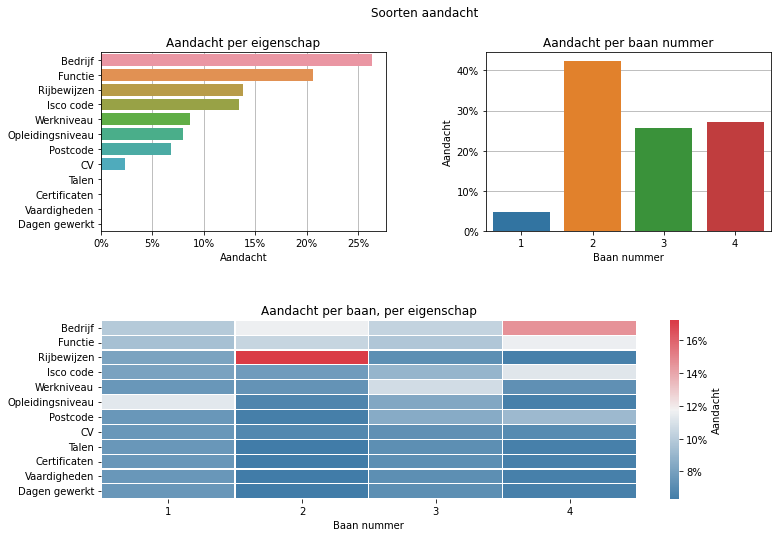

KeyboardInterrupt: Interrupted by user

In [109]:
draw_explanation(lstm, trainloader, embedding_sizes, feature_names, batch=False,
                 enforce_correct=True, group="Customer_support", min_len=4, max_len=8, lang="nl")